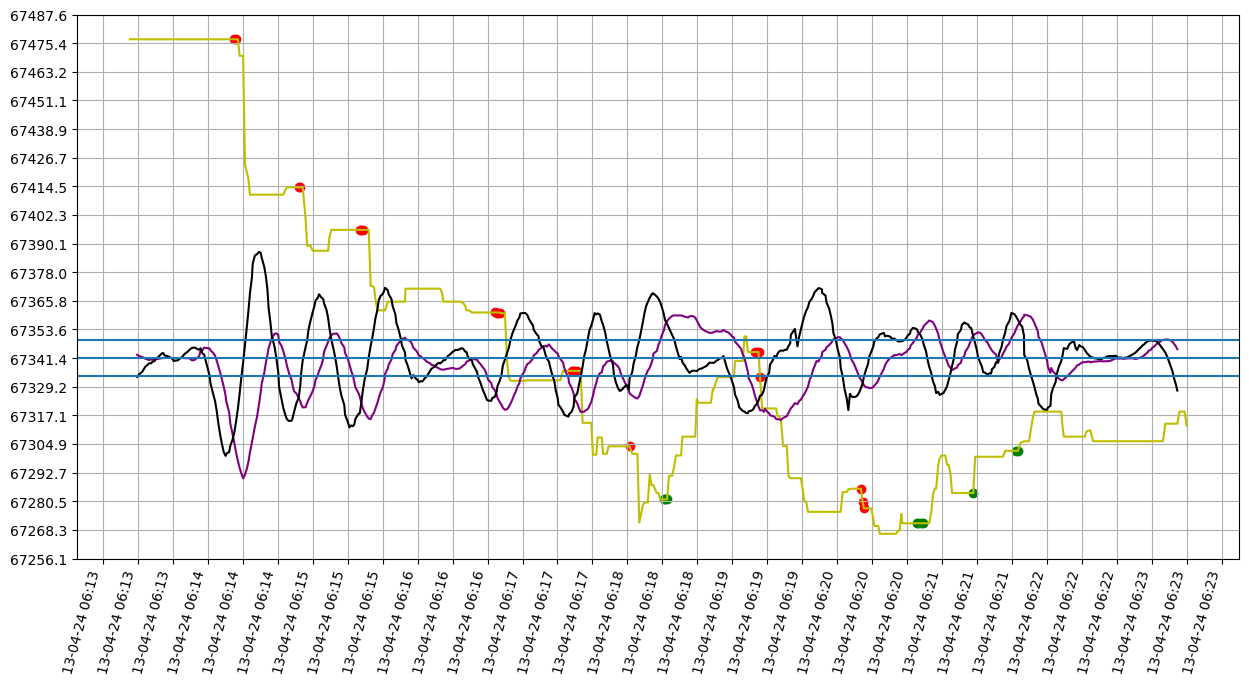

In [2]:
################################################################################################################################################################################
# Importamos las librerías necesarias y generamos conexión con Binance para descargar la lista de pares que binance maneja.
################################################################################################################################################################################
import pandas as pd
import os
import numpy as np
from datetime import datetime
import sympy as sp
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from binance import Client
from time import sleep
from IPython.display import clear_output

client = Client()

##################################################
# Lista de parámetros.
##################################################
# Parámetros de interpolación.
###################################
smooth_interval = 30
smooth_exp = 3
###################################
# Parámetros de estrategia.
###################################
rango = 5
std_mult = 40
pdi_mult = 10
sdi_mult = 100
z_aprox = 0.01
# z_aprox = 0.1
pmax_idx = 0
pmin_idx = 0


while True:
    clear_output(wait=True)
    ##################################################################################################################################
    # Descarga y limpieza de datos de X días atrás a hoy.
    ##################################################################################################################################
    recent_data = pd.read_csv('../../csvs/streaming/BTCUSDT.csv')
    recent_data.columns = ['Tiempo','Simbolo','Open']
    recent_data = recent_data.loc[:,['Tiempo','Open']]
    recent_data['Tiempo'] = recent_data.Tiempo.astype('datetime64')
    recent_data = recent_data.set_index('Tiempo')
    recent_data['Open'] = recent_data.Open.astype(float)
    recent_data = recent_data.reset_index()

    ##################################################
    # Interpolación (suavizado)  del Precio (OPEN) con SciPy y obtención de derivadas con su respectiva interpolación.
    ##################################################
    recent_data['Interpolacion'] = sc.signal.savgol_filter(recent_data.Open,smooth_interval,3)
    recent_data['Primer_Derivada'] = recent_data.Interpolacion.diff()/(recent_data.Tiempo.diff()/np.timedelta64(1, 's'))
    recent_data['PD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Primer_Derivada,smooth_interval,3)
    recent_data['Segunda_Derivada'] = recent_data.PD_Interpolacion.diff()/(recent_data.Tiempo.diff()/np.timedelta64(1, 's'))
    recent_data['SD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Segunda_Derivada,smooth_interval,3)
    recent_data['Tercer_Derivada'] = recent_data.SD_Interpolacion.diff()/(recent_data.Tiempo.diff()/np.timedelta64(1, 's'))
    recent_data['TD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Tercer_Derivada,smooth_interval,3)

    ######################################################################
    # Agregamos el código necesario para encontrar los puntos exactos mínimos y máximos
    ######################################################################
    try:
        initial_date_index = recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo[-60*10:-60*10 + 1].item()),'%Y-%m-%d %H:%M:%S.%f')].index.item() + rango
    except:
        initial_date_index = recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo[-60*10:-60*10 + 1].item()),'%Y-%m-%d %H:%M:%S')].index.item() + rango
    try:
        final_date_index = recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo[-1:].item()),'%Y-%m-%d %H:%M:%S.%f')].index.item() - rango
    except:
        final_date_index = recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo[-1:].item()),'%Y-%m-%d %H:%M:%S')].index.item() - rango


    lista_min_max = recent_data[initial_date_index:final_date_index][(recent_data[initial_date_index:final_date_index].TD_Interpolacion >= -z_aprox) & (recent_data[initial_date_index:final_date_index].TD_Interpolacion <= z_aprox)]
    indices_min_max = lista_min_max.index.tolist()

    max_points_idx = []
    min_points_idx = []
    pmin = 0
    pmax = 0

    for PMSD in indices_min_max:
        if (recent_data.SD_Interpolacion[PMSD:PMSD+1].item() > 0) & (recent_data.PD_Interpolacion[PMSD:PMSD+1].item() > 0):
            if (abs(recent_data.SD_Interpolacion[PMSD]*10) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD]*pdi_mult) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
                pmax = recent_data.SD_Interpolacion[PMSD]
            for i in range(rango+1):
                if (i > PMSD) or (PMSD+i >= indices_min_max[-1:][0]):
                    break
                elif ((recent_data.SD_Interpolacion[PMSD-i] > pmax)) & ((abs(recent_data.SD_Interpolacion[PMSD-i]*sdi_mult)) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD-i]*pdi_mult) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
                    pmax_idx = PMSD-i
                elif ((recent_data.SD_Interpolacion[PMSD+i] > pmax)) & ((abs(recent_data.SD_Interpolacion[PMSD+i]*sdi_mult)) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD+i]*pdi_mult) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
                    pmax_idx = PMSD+i
            max_points_idx.append(pmax_idx)
        elif (recent_data.SD_Interpolacion[PMSD:PMSD+1].item()) < 0 & (recent_data.PD_Interpolacion[PMSD:PMSD+1].item() < 0):
            if (abs(recent_data.SD_Interpolacion[PMSD]*10) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD]*pdi_mult) < -abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
                pmin = recent_data.SD_Interpolacion[PMSD]
            for i in range(rango+1):
                if (i > PMSD) or (PMSD+i >= indices_min_max[-1:][0]):
                    break
                elif ((recent_data.SD_Interpolacion[PMSD-i] < pmin)) & (abs(recent_data.SD_Interpolacion[PMSD-i]*sdi_mult) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD-i]*pdi_mult) < -abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
                    pmin_idx = PMSD-i
                elif ((recent_data.SD_Interpolacion[PMSD+i] < pmin)) & (abs(recent_data.SD_Interpolacion[PMSD+i]*sdi_mult) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD+i]*pdi_mult) < -abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
                    pmin_idx = PMSD+i
            min_points_idx.append(pmin_idx)
    max_points_idx = list(set(max_points_idx))
    min_points_idx = list(set(min_points_idx))
    max_points_idx.sort()
    min_points_idx.sort()

    # close_points_max = []
    # close_points_min = []
    # for lista in [max_points_idx,min_points_idx]:
    #     for i in range(len(lista)-1):
    #         if lista[i+1]-lista[i] <= 2:
    #             if lista == max_points_idx:
    #                 close_points_max.append(i+1)
    #             else:
    #                 close_points_min.append(i+1)
    #     if lista == max_points_idx:
    #         for idx in sorted(close_points_max,reverse=True):
    #             del lista[idx]
    #     else:
    #         for idx in sorted(close_points_min,reverse=True):
    #             del lista[idx]

    ######################################################################
    # Ahora ya podemos visualizar los resultados con el siguiente código.
    ######################################################################
    mp = recent_data.Open[initial_date_index:final_date_index].mean()
    plt.figure(figsize=(15,8))
    plt.plot(recent_data.Tiempo[initial_date_index - rango:final_date_index + rango],recent_data.Open[initial_date_index - rango:final_date_index + rango].multiply(1),color='y')
    plt.plot(recent_data.Tiempo[initial_date_index:final_date_index],recent_data.PD_Interpolacion[initial_date_index:final_date_index].multiply(10)+mp,'purple')
    plt.plot(recent_data.Tiempo[initial_date_index:final_date_index],recent_data.SD_Interpolacion[initial_date_index:final_date_index].multiply(100)+mp,color='k')
    # plt.plot(recent_data.Tiempo[initial_date_index:final_date_index],recent_data.TD_Interpolacion[initial_date_index:final_date_index].multiply(300)+mp,color='y')
    plt.scatter(recent_data.Tiempo.iloc[max_points_idx],recent_data.Open.iloc[max_points_idx],color='g')
    plt.scatter(recent_data.Tiempo.iloc[min_points_idx],recent_data.Open.iloc[min_points_idx],color='r')
    plt.grid(visible=True)

    # Set minor tick locations.
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y %H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.SecondLocator(interval=20))
    plt.gca().yaxis.set_major_locator(ticker.LinearLocator(20))
    plt.gcf().autofmt_xdate()

    # Set grid to use minor tick locations. 
    plt.grid(which = 'minor')
    plt.xticks(rotation=75)
    plt.axhline(mp)
    plt.axhline(np.std(recent_data.SD_Interpolacion)*std_mult + mp)
    plt.axhline(mp - np.std(recent_data.SD_Interpolacion)*std_mult)
    # plt.axvline(datetime.strptime('2024-04-04 09:59:00','%Y-%m-%d %H:%M:%S'))
    plt.show()
    # sleep(15)

In [8]:
recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo[-60*3:-60*3 + 1].item()),'%Y-%m-%d %H:%M:%S.%f')].index.item() + rango


ValueError: can only convert an array of size 1 to a Python scalar

In [10]:
recent_data

,Tiempo,Open,Interpolacion,Primer_Derivada,PD_Interpolacion,Segunda_Derivada,SD_Interpolacion,Tercer_Derivada,TD_Interpolacion
0,2024-04-12 23:02:31.441,67016.51,67029.674331,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-04-12 23:02:31.745,67025.11,67023.951647,-18.824621,NaN,NaN,NaN,NaN,NaN
2,2024-04-12 23:02:33.995,67038.55,67019.026996,-2.188734,NaN,NaN,NaN,NaN,NaN
3,2024-04-12 23:02:45.097,67009.74,67014.847982,-0.376420,NaN,NaN,NaN,NaN,NaN
4,2024-04-12 23:02:46.531,67025.13,67011.362210,-2.430803,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
56,2024-04-12 23:06:26.809,66978.16,66983.482670,-0.325984,21.662636,-0.897009,-35.748754,0.355393,-99.763646
57,2024-04-12 23:06:35.444,66953.29,66978.126582,-0.620277,9.724488,-1.382530,-27.745347,0.926857,-53.391979
58,2024-04-12 23:06:36.178,66978.16,66970.942956,-9.786957,-4.084641,-18.813527,-15.335168,16.907601,2.258169
59,2024-04-12 23:06:50.295,66953.29,66961.767922,-0.649928,-19.858005,-1.117331,1.910689,1.221638,67.782860
